In [1]:
import pandas as pd
import numpy as np
import re
import awswrangler as wr
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

### Read the data from `clensed_data` table from Athena

In [2]:
df = wr.athena.read_sql_query(
    sql="SELECT * FROM {}".format('clensed_data'), database='dev'
)
print(type(df))
df.head(10)

<class 'pandas.core.frame.DataFrame'>


,id,post,comment,interactions,users,timestamp,year,month,day
0,zvbEMd8AoA7iO38W,Came across this admire. It was impressive. A ...,Ive been there too It was glorious. I highly r...,"{'interaction_id': 40687, 'user1_id': 1052, 'u...","{'user_id': 2640, 'user_name': 'User 2640', 'u...",2023-07-13 16:29:59.647,2023,7,13
1,aHCxUIVosUej3xqP,Came across this pilgrimage. It was spectacula...,Sorry to hear that. Far from impressive.,"{'interaction_id': 13518, 'user1_id': 2691, 'u...","{'user_id': 6029, 'user_name': 'User 6029', 'u...",2023-07-13 16:30:23.643,2023,7,13
2,f3k5ts51cfNaCXml,Avoiding Toronto because its optimistic. Wish ...,Neutral feelings about the surfing competition...,"{'interaction_id': 80421, 'user1_id': 4422, 'u...","{'user_id': 4477, 'user_name': 'User 4477', 'u...",2023-07-13 16:30:23.643,2023,7,13
3,2yIFPEshTt64KuoU,Came across this journey. It was adventurous. ...,Interesting. Nothing remarkable to report.,"{'interaction_id': 62174, 'user1_id': 6765, 'u...","{'user_id': 2301, 'user_name': 'User 2301', 'u...",2023-07-13 16:30:23.643,2023,7,13
4,MzrE0x7FTruSbsl8,Not impressed with this conquer. Its empowerin...,Thanks for sharing. Ill definitely experienced...,"{'interaction_id': 26181, 'user1_id': 5132, 'u...","{'user_id': 2374, 'user_name': 'User 2374', 'u...",2023-07-13 16:30:23.643,2023,7,13
5,IRMQf87NQdVaDPzc,Neutral feelings about Auckland. It was fantas...,Interesting. Neutral vibes.,"{'interaction_id': 92619, 'user1_id': 4440, 'u...","{'user_id': 4667, 'user_name': 'User 4667', 'u...",2023-07-13 16:30:34.618,2023,7,13
6,EW8wqjUBokUTyRMp,I just visited Havana and it was dynamic Im st...,Interesting. Nothing extraordinary.,"{'interaction_id': 55233, 'user1_id': 8682, 'u...","{'user_id': 7223, 'user_name': 'User 7223', 'u...",2023-07-13 16:30:34.618,2023,7,13
7,pgrJfG8FjEdTFV9a,Having a great time at flea market. Its engagi...,"Wow, that pilgrimage looks vibrant A positive ...","{'interaction_id': 97311, 'user1_id': 2285, 'u...","{'user_id': 9854, 'user_name': 'User 9854', 'u...",2023-07-13 16:30:34.618,2023,7,13
8,0VCYwg475GOqNGzk,Not impressed with this escape. Its stunning. ...,Im neutral about Los Angeles. Its blissful. No...,"{'interaction_id': 23489, 'user1_id': 7511, 'u...","{'user_id': 6929, 'user_name': 'User 6929', 'u...",2023-07-13 16:30:07.088,2023,7,13
9,k7QcIDmdz7HW3XyN,Having a great time at gaming tournament. Its ...,I had a different experience at Vancouver. It ...,"{'interaction_id': 15443, 'user1_id': 8279, 'u...","{'user_id': 7109, 'user_name': 'User 7109', 'u...",2023-07-13 16:30:18.870,2023,7,13


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5370 entries, 0 to 5369
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            5370 non-null   string        
 1   post          5370 non-null   string        
 2   comment       5370 non-null   string        
 3   interactions  5370 non-null   object        
 4   users         5370 non-null   object        
 5   timestamp     5370 non-null   datetime64[ns]
 6   year          5370 non-null   string        
 7   month         5370 non-null   string        
 8   day           5370 non-null   string        
dtypes: datetime64[ns](1), object(2), string(6)
memory usage: 377.7+ KB


### Dropping all the unecessary columns

In [4]:
analysis_df = df.drop(['interactions', 'users', 'timestamp', 'year', 'month', 'day'], axis=1)
analysis_df.head()

,id,post,comment
0,zvbEMd8AoA7iO38W,Came across this admire. It was impressive. A ...,Ive been there too It was glorious. I highly r...
1,aHCxUIVosUej3xqP,Came across this pilgrimage. It was spectacula...,Sorry to hear that. Far from impressive.
2,f3k5ts51cfNaCXml,Avoiding Toronto because its optimistic. Wish ...,Neutral feelings about the surfing competition...
3,2yIFPEshTt64KuoU,Came across this journey. It was adventurous. ...,Interesting. Nothing remarkable to report.
4,MzrE0x7FTruSbsl8,Not impressed with this conquer. Its empowerin...,Thanks for sharing. Ill definitely experienced...


In [5]:
print(analysis_df['post'].iloc[0],"\n")
print(analysis_df['post'].iloc[1],"\n")
print(analysis_df['post'].iloc[2],"\n")
print(analysis_df['post'].iloc[3],"\n")
print(analysis_df['post'].iloc[4],"\n")

Came across this admire. It was impressive. A mixed bag. 

Came across this pilgrimage. It was spectacular. Decent but not outstanding. 

Avoiding Toronto because its optimistic. Wish I had chosen differently. 

Came across this journey. It was adventurous. Middle of the road. 

Not impressed with this conquer. Its empowering. A waste of time. 



### Function for data preprocessing

Removes all the special characters
Tokenizes the texts and removes the stop_words which are not useful for analysis

In [6]:
def data_processing(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','',text)
    text = re.sub(r'[^\w\s]','',text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)
    

In [7]:
analysis_df['post'] = analysis_df['post'].apply(data_processing)
analysis_df['comment'] = analysis_df['comment'].apply(data_processing)


In [8]:
# dropping duplicates
analysis_df = analysis_df.drop_duplicates('post').drop_duplicates('comment')

### Stemming is used to extract the base form of the words by removing affixes from them

In [9]:
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [10]:
analysis_df['post'] = analysis_df['post'].apply(lambda x: stemming(x))

In [11]:
analysis_df.head()

,id,post,comment
0,zvbEMd8AoA7iO38W,came across admire impressive mixed bag,ive glorious highly recommend
1,aHCxUIVosUej3xqP,came across pilgrimage spectacular decent outs...,sorry hear far impressive
2,f3k5ts51cfNaCXml,avoiding toronto optimistic wish chosen differ...,neutral feelings surfing competition decent ou...
3,2yIFPEshTt64KuoU,came across journey adventurous middle road,interesting nothing remarkable report
4,MzrE0x7FTruSbsl8,impressed conquer empowering waste time,thanks sharing ill definitely experienced appr...


### Polarity is used to determine the sentiment of the text

In [12]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [13]:
analysis_df['post_polarity'] = analysis_df['post'].apply(polarity)
analysis_df['comment_polarity'] = analysis_df['comment'].apply(polarity)
analysis_df.head()

,id,post,comment,post_polarity,comment_polarity
0,zvbEMd8AoA7iO38W,came across admire impressive mixed bag,ive glorious highly recommend,0.500000,0.160000
1,aHCxUIVosUej3xqP,came across pilgrimage spectacular decent outs...,sorry hear far impressive,0.422222,0.200000
2,f3k5ts51cfNaCXml,avoiding toronto optimistic wish chosen differ...,neutral feelings surfing competition decent ou...,0.000000,0.333333
3,2yIFPEshTt64KuoU,came across journey adventurous middle road,interesting nothing remarkable report,0.250000,0.625000
4,MzrE0x7FTruSbsl8,impressed conquer empowering waste time,thanks sharing ill definitely experienced appr...,0.400000,0.200000


### Labeling the sentences as `Positive`, `Negative` or `Neutral` based on the polarity

In [14]:
def sentiment(label):
    if label < 0:
        return "Negative"
    elif label == 0:
        return "Neutral"
    elif label > 0:
        return"Positive"

In [15]:
analysis_df['post_sentiment'] = analysis_df['post_polarity'].apply(sentiment)
analysis_df['comment_sentiment'] = analysis_df['comment_polarity'].apply(sentiment)
analysis_df.head()

,id,post,comment,post_polarity,comment_polarity,post_sentiment,comment_sentiment
0,zvbEMd8AoA7iO38W,came across admire impressive mixed bag,ive glorious highly recommend,0.500000,0.160000,Positive,Positive
1,aHCxUIVosUej3xqP,came across pilgrimage spectacular decent outs...,sorry hear far impressive,0.422222,0.200000,Positive,Positive
2,f3k5ts51cfNaCXml,avoiding toronto optimistic wish chosen differ...,neutral feelings surfing competition decent ou...,0.000000,0.333333,Neutral,Positive
3,2yIFPEshTt64KuoU,came across journey adventurous middle road,interesting nothing remarkable report,0.250000,0.625000,Positive,Positive
4,MzrE0x7FTruSbsl8,impressed conquer empowering waste time,thanks sharing ill definitely experienced appr...,0.400000,0.200000,Positive,Positive


### Writes the dataframe to S3 after doing sentiment analysis on posts and comments

In [16]:
import datetime
timestamp = datetime.datetime.now()
year = timestamp.strftime("%Y")
month = timestamp.strftime("%m")
day = timestamp.strftime("%d") 
analysis_df.to_parquet(f's3://assignment-analytics-bucket/analysed_data/{year}/{month}/{day}/{str(datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S"))}.parquet')
print('Loaded data to S3!')

Loaded data to S3!


### Plotting the sentiments into a graph

<Axes: xlabel='post_sentiment', ylabel='count'>

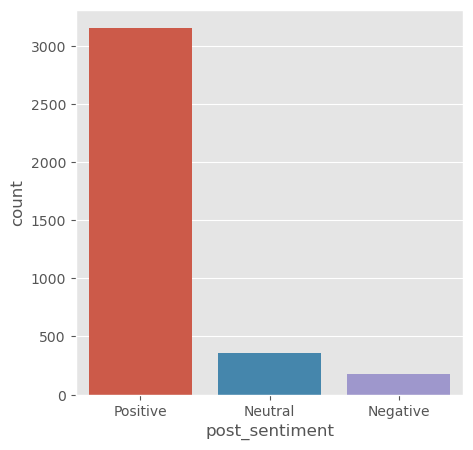

In [17]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='post_sentiment', data = analysis_df)

Text(0.5, 1.0, 'Distribution of sentiments')

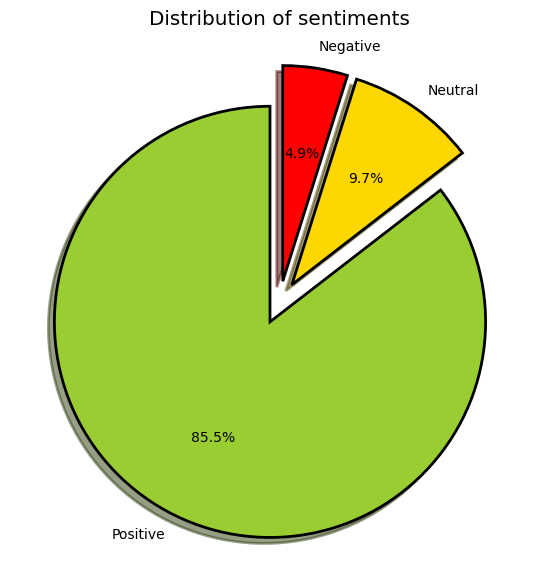

In [18]:
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor': 'black'}
tags = analysis_df['post_sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors=colors,
         startangle=90, wedgeprops=wp, explode=explode, label='')
plt.title("Distribution of sentiments")

### A word cloud of the positive posts

In [19]:
pos_posts = analysis_df[analysis_df.post_sentiment == 'Positive']
pos_posts = pos_posts.sort_values(['post_polarity'], ascending=False)
pos_posts.head()

,id,post,comment,post_polarity,comment_polarity,post_sentiment,comment_sentiment
4059,ZT3ZUkFUEZo7Ya6Z,impressed explore serene par,sure would enjoy sports event disappointing ov...,1.0,0.075000,Positive,Positive
3970,DQe4rmWG6A0VmtiV,avoiding shanghai marvelous par,different experience new york city heartwarmin...,1.0,0.068182,Positive,Positive
5057,QtZEvfhouQAzpiLA,visited helsinki delightful im still awe,thanks sharing ill definitely cherished discov...,1.0,-0.100000,Positive,Negative
836,bs8nvzlow2hpWyTN,impressed admire euphoric underwhelming experi...,thanks sharing ill definitely cherished embrac...,1.0,-0.100000,Positive,Negative
1794,PNeRfHIZbofTSTsO,avoiding los angeles excellent underwhelming e...,different experience singapore resplendent dis...,1.0,-0.200000,Positive,Negative


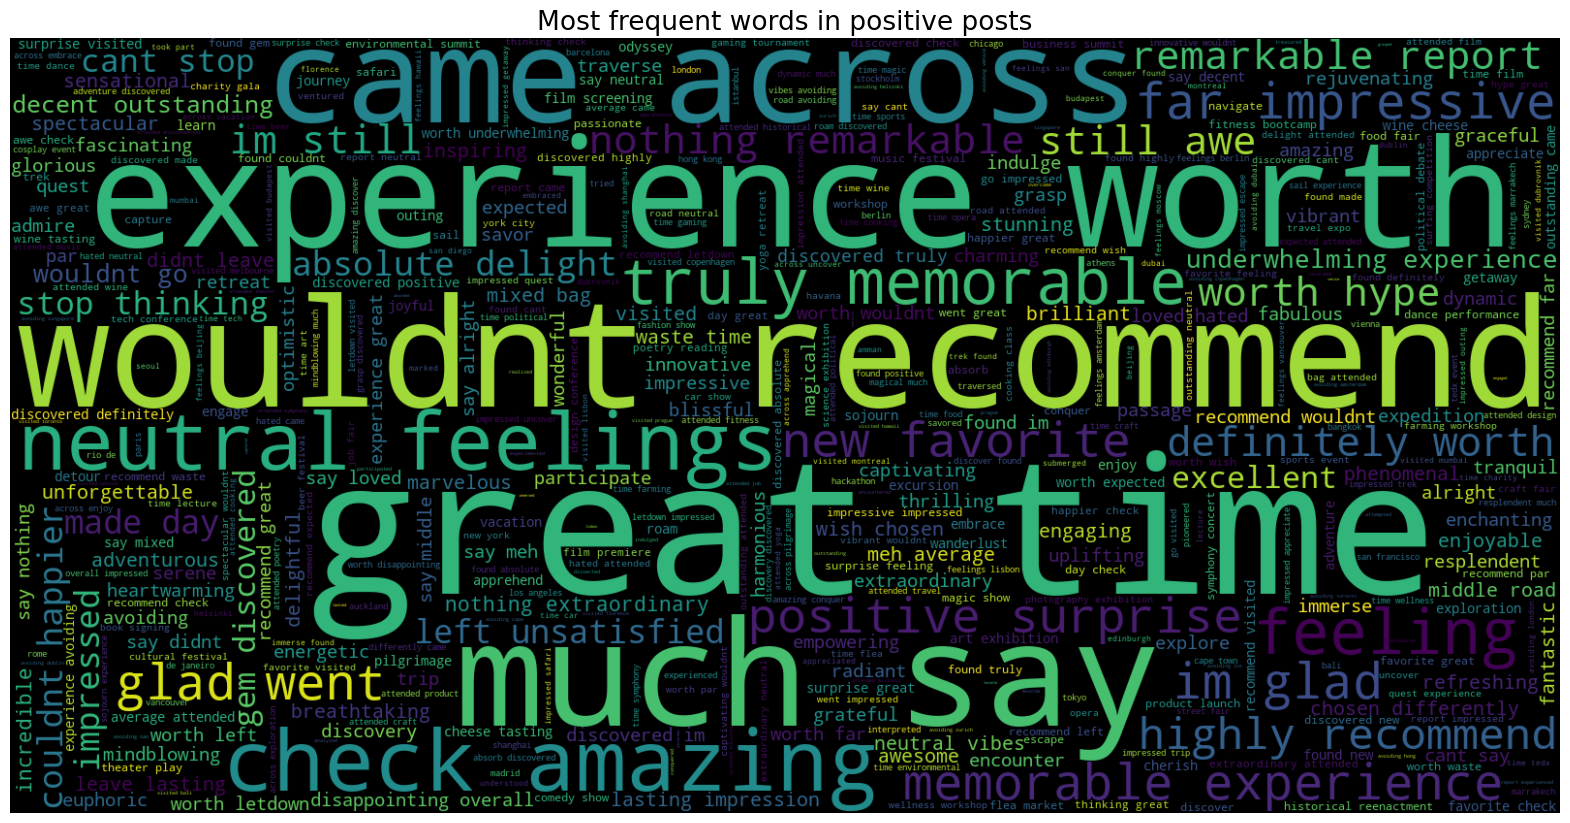

In [20]:
text = ' '.join([word for word in pos_posts['post']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600,height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most frequent words in positive posts", fontsize=19)
plt.show()

### A word cloud of the negative posts

In [21]:
neg_posts = analysis_df[analysis_df.post_sentiment == 'Negative']
neg_posts = neg_posts.sort_values(['post_polarity'], ascending=False)
neg_posts.head()

,id,post,comment,post_polarity,comment_polarity,post_sentiment,comment_sentiment
2468,CDUa2EFZboEFQmAu,attended historical reenactment grateful much ...,sounds outstanding cant wait attempted outing ...,-2.775558e-17,0.50,Negative,Positive
3024,zMHJJXEc2AqFIbWd,attended cosplay event dynamic much say cant s...,thanks sharing ill definitely tried sojourn im...,-2.775558e-17,0.05,Negative,Positive
886,lLE2u65noNrstJQ8,attended historical reenactment joyful much sa...,neutral feelings magic show middle road,-2.775558e-17,0.25,Negative,Positive
704,4Y4DuIxy81YFgt6X,attended cooking class glorious much say cant ...,im neutral san diego unforgettable mixed bag,-3.700743e-17,0.40,Negative,Positive
3899,HhF4oAz7n8RgMwQC,attended opera glorious much say cant say love...,agree amman always tranquil absolute delight,-3.700743e-17,0.20,Negative,Positive


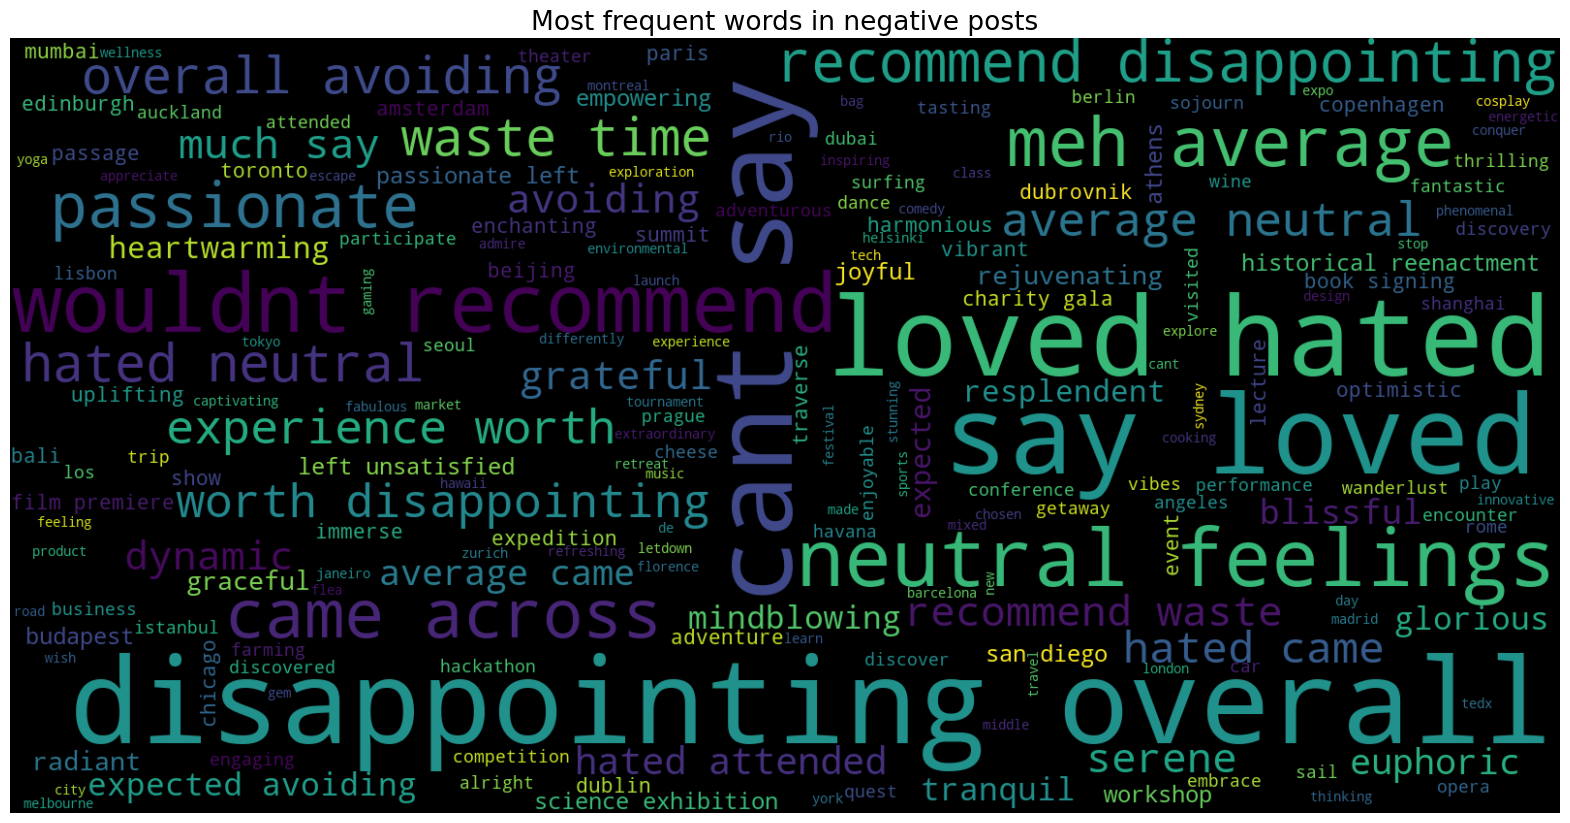

In [22]:
text = ' '.join([word for word in neg_posts['post']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600,height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most frequent words in negative posts", fontsize=19)
plt.show()

### Creating a bigram model

In [23]:
vect = CountVectorizer(ngram_range=(1,2)).fit(analysis_df['post'])

In [24]:
feature_names = vect.get_feature_names_out()
print('Number of features: {}\n'.format(len(feature_names)))
print('First 20 features:\n {}'.format(feature_names[:20]))

Number of features: 5545

First 20 features:
 ['absolute' 'absolute delight' 'absorb' 'absorb awesome' 'absorb charming'
 'absorb discovered' 'absorb experience' 'absorb extraordinary'
 'absorb found' 'absorb graceful' 'absorb incredible' 'absorb spectacular'
 'absorb stunning' 'absorb uplifting' 'absorb vibrant' 'absorbed'
 'absorbed amazing' 'absorbed engaging' 'absorbed fantastic'
 'absorbed outstanding']


In [25]:
X = analysis_df['post']
Y = analysis_df['post_sentiment']
X = vect.transform(X)

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)

In [27]:
print('Size of x_train:', (x_train.shape))
print('Size of y_train:', (y_train.shape))
print('Size of x_test:', (x_test.shape))
print('Size of y_test:', (y_test.shape))

Size of x_train: (2952, 5545)
Size of y_train: (2952,)
Size of x_test: (738, 5545)
Size of y_test: (738,)


### Training the data on LogisticRegression model

In [28]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_pred = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 97.15%


In [29]:
print(confusion_matrix(y_test, logreg_pred))
print("\n")
print(classification_report(y_test, logreg_pred))

[[ 27   2  12]
 [  0  71   2]
 [  2   3 619]]


              precision    recall  f1-score   support

    Negative       0.93      0.66      0.77        41
     Neutral       0.93      0.97      0.95        73
    Positive       0.98      0.99      0.98       624

    accuracy                           0.97       738
   macro avg       0.95      0.87      0.90       738
weighted avg       0.97      0.97      0.97       738



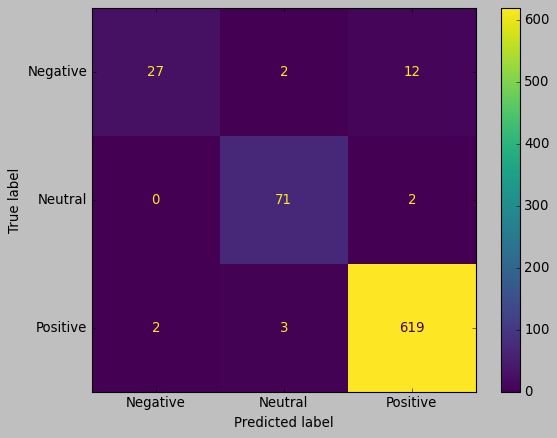

In [30]:
style.use('classic')
cm = confusion_matrix(y_test, logreg_pred, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=logreg.classes_)
disp.plot()

### Hyperparameter tuning using GridSearchCV

Since we are using LogisticRegression we will be performing the tuning over the `C` parameter


In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
param_grid={'C':[0.001, 0.01, 0.01, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid)
grid.fit(x_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.01, 1, 10]})

In [33]:
print("Best parameters: ", grid.best_params_)

Best parameters:  {'C': 10}


In [34]:
y_pred = grid.predict(x_test)

In [35]:
logreg_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 97.97%


In [36]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[ 33   2   6]
 [  1  71   1]
 [  2   3 619]]


              precision    recall  f1-score   support

    Negative       0.92      0.80      0.86        41
     Neutral       0.93      0.97      0.95        73
    Positive       0.99      0.99      0.99       624

    accuracy                           0.98       738
   macro avg       0.95      0.92      0.93       738
weighted avg       0.98      0.98      0.98       738



### Running the algorithm on support vectore machine

In [37]:
from sklearn.svm import LinearSVC

In [38]:
SVCmodel = LinearSVC()
SVCmodel.fit(x_train, y_train)

LinearSVC()

In [39]:
svc_pred = SVCmodel.predict(x_test)
svc_acc = accuracy_score(svc_pred, y_test)
print("Test accuracy: {:.2f}%".format(svc_acc*100))

Test accuracy: 98.92%


In [40]:
print(confusion_matrix(y_test, svc_pred))
print("\n")
print(classification_report(y_test, svc_pred))

[[ 38   2   1]
 [  0  72   1]
 [  2   2 620]]


              precision    recall  f1-score   support

    Negative       0.95      0.93      0.94        41
     Neutral       0.95      0.99      0.97        73
    Positive       1.00      0.99      1.00       624

    accuracy                           0.99       738
   macro avg       0.96      0.97      0.97       738
weighted avg       0.99      0.99      0.99       738



### Hyperparameter tuning using GridSearchCV


In [41]:
grid = {
    'C': [0.01,0.1,1,10],
    'kernel':['linear','poly','rbf','sigmoid'],
    'degree':[1,3,5,7],
    'gamma':[0.01,1]
}
grid = GridSearchCV(SVCmodel,param_grid)
grid.fit(x_train,y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(estimator=LinearSVC(),
             param_grid={'C': [0.001, 0.01, 0.01, 1, 10]})

In [42]:
print("Best parameters: ", grid.best_params_)

Best parameters:  {'C': 1}


In [43]:
y_pred = grid.predict(x_test)

In [44]:
logreg_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 98.92%


In [45]:
print(confusion_matrix(y_test, svc_pred))
print("\n")
print(classification_report(y_test, svc_pred))

[[ 38   2   1]
 [  0  72   1]
 [  2   2 620]]


              precision    recall  f1-score   support

    Negative       0.95      0.93      0.94        41
     Neutral       0.95      0.99      0.97        73
    Positive       1.00      0.99      1.00       624

    accuracy                           0.99       738
   macro avg       0.96      0.97      0.97       738
weighted avg       0.99      0.99      0.99       738

